In [37]:
import time
import rasterio
import numpy as np
import starfm4py as stp
import matplotlib.pyplot as plt
from parameters import (path, sizeSlices)
%matplotlib inline

In [38]:
start = time.time()

#Set the path where the images are stored
product = rasterio.open('Tests/Test_3/sim_Landsat_t1.tif')
# store product file info
profile = product.profile
LandsatT0 = rasterio.open('Tests/Test_3/sim_Landsat_t1.tif').read(1)
MODISt0 = rasterio.open('Tests/Test_3/sim_MODIS_t1.tif').read(1)
MODISt1 = rasterio.open('Tests/Test_3/sim_MODIS_t4.tif').read(1)

# Set the path where to store the temporary results
path_fineRes_t0 = 'Temporary/Tiles_fineRes_t0/'
path_coarseRes_t0 = 'Temporary/Tiles_coarseRes_t0/'
path_coarseRes_t1 = 'Temporary/Tiles_fcoarseRes_t1/'

# Flatten and store the moving window patches
fine_image_t0_par = stp.partition(LandsatT0, path_fineRes_t0)
coarse_image_t0_par = stp.partition(MODISt0, path_coarseRes_t0)
coarse_image_t1_par = stp.partition(MODISt1, path_coarseRes_t1)

print ("Done partitioning!")

# Stack the moving window patches as dask arrays
S2_t0 = stp.da_stack(path_fineRes_t0, LandsatT0.shape)
S3_t0 = stp.da_stack(path_coarseRes_t0, MODISt0.shape)
S3_t1 = stp.da_stack(path_coarseRes_t1, MODISt1.shape)

shape = (sizeSlices, LandsatT0.shape[1])

print ("Done stacking!")

/home/gpetr/anaconda3/envs/fusion/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Done partitioning!
Done stacking!


In [39]:
shape

(150, 150)

(150, 150)


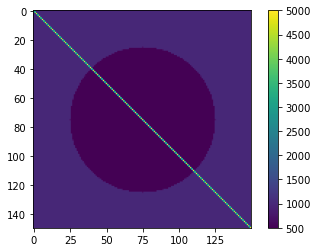

In [40]:
print(LandsatT0.shape)
plt.imshow(LandsatT0)
plt.colorbar()
plt.show()

(150, 150)


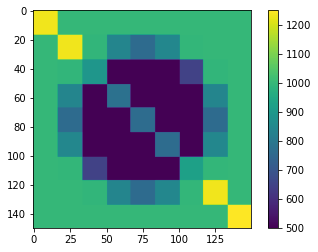

In [41]:
print(MODISt0.shape)
plt.imshow(MODISt0)
plt.colorbar()
plt.show()

(150, 150)


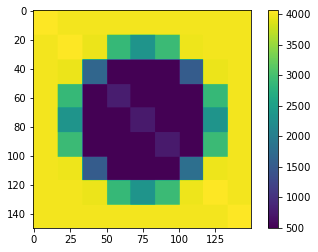

In [42]:
print(MODISt1.shape)
plt.imshow(MODISt1)
plt.colorbar()
plt.show()

In [43]:
# Perform the prediction with STARFM
for i in range(0, LandsatT0.size-sizeSlices*shape[1]+1, sizeSlices*shape[1]):
    
    fine_image_t0 = S2_t0[i:i+sizeSlices*shape[1],]
    coarse_image_t0 = S3_t0[i:i+sizeSlices*shape[1],]
    coarse_image_t1 = S3_t1[i:i+sizeSlices*shape[1],]
    print(fine_image_t0.shape, coarse_image_t0.shape, coarse_image_t1.shape)
    prediction = stp.starfm(fine_image_t0, coarse_image_t0, coarse_image_t1, profile, shape)
    
    if i == 0:
        predictions = prediction
        
    else:
        predictions = np.append(predictions, prediction, axis=0)

(22500, 961) (22500, 961) (22500, 961)
Processing...
Done spectral distance! dask.array<truediv, shape=(22500, 961), dtype=float64, chunksize=(150, 961), chunktype=numpy.ndarray>
Done temporal distance! dask.array<truediv, shape=(22500, 961), dtype=float64, chunksize=(150, 961), chunktype=numpy.ndarray>
Done spatial distance! dask.array<array, shape=(961,), dtype=float64, chunksize=(961,), chunktype=numpy.ndarray>
Done comb distance! dask.array<mul, shape=(22500, 961), dtype=float64, chunksize=(150, 961), chunktype=numpy.ndarray>
Done similarity threshold! dask.array<truediv, shape=(22500,), dtype=float64, chunksize=(150,), chunktype=numpy.ndarray>
Done similarity pixels! dask.array<where, shape=(22500, 961), dtype=int64, chunksize=(150, 961), chunktype=numpy.ndarray>
Done filtering! dask.array<mul, shape=(22500, 961), dtype=int64, chunksize=(150, 961), chunktype=numpy.ndarray>
Done weighting! dask.array<rechunk-merge, shape=(22500, 961), dtype=float64, chunksize=(150, 961), chunktype=

In [44]:
# Write the results to a .tif file   
print ('Writing product...')
profile = product.profile
profile.update(dtype='float64', count=1) # number of bands
file_name = path + 'prediction.tif'

result = rasterio.open(file_name, 'w', **profile)
result.write(predictions, 1)
result.close()


end = time.time()
print ("Done in", (end - start)/60.0, "minutes!")

Writing product...
Done in 0.2765242417653402 minutes!


/home/gpetr/anaconda3/envs/fusion/lib/python3.7/site-packages/rasterio/__init__.py:229: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


(150, 150)


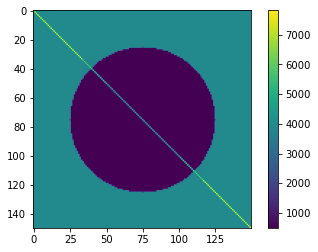

In [45]:
print(predictions.shape)
plt.imshow(predictions)
plt.colorbar()
plt.show()